In [8]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import salmask, latweights, makedz, lon180

In [2]:
datafolder = ''

In [3]:
experiment = 'E280' 
model = 'HadCM3'
folder = datafolder+'Raw_data/'+model+'/'

In [4]:
if experiment == 'E280':
    ds = xr.open_dataset(folder+experiment+'/E280_2900-2999_Annual.nc')
    dsr = xr.open_dataset(folder+'/Region_file.nc')
elif experiment == 'Eoi400':
    ds = xr.open_dataset(folder+experiment+'/Eoi400_2400-2499_Annual.nc')
    dsr = xr.open_dataset(folder+'/Region_file.nc')

## Separation MOC and gyre FW Atlantic

In [5]:
vvel = ds.field704
salt = ds.salinity

#Atlantic Ocean region
regiont = dsr.region

In [6]:
#1-D array with spacing of depth grid
dz2 = np.zeros(len(ds.z2))
dz2[0] = ds.z2[0].values*2
depth = dz2[0]
for i in range(1,len(ds.z2)):
    dz2[i] = (ds.z2[i].values-depth)*2
    depth = depth+dz2[i]
dz2 = dz2*100 #Depth spacing. Units: cm
ds['dz2'] = xr.DataArray(data=dz2, dims=("z2"))
dz2 = ds.dz2

#2-D array with spacing of horizontal grid 
r = 6.37122e8 #radius Earth in cm
dlon2 = np.deg2rad(1.25)*r*np.cos(np.deg2rad(ds.lat1)) #Lon spacing. Units: cm. Interpolating to the T-grid

a = dlon2
dlon2 = np.zeros([len(ds.lat1),len(ds.lon2)])
for i in range(len(ds.lon2)):
    dlon2[:,i]=a.values
ds['dlon2']=xr.DataArray(data = dlon2, dims=("lat1","lon2"))
dlon2 = ds.dlon2

In [9]:
#Define reference salinity S0 as average salinity Atlantic Ocean
folder2 = datafolder+'Processed/'
dssalt = xr.open_dataset(folder2+model+'/'+experiment+'/so_1x1_100yr.nc')
dssalt = lon180(dssalt)

S0 = dssalt.so.where(salmask()>-1).weighted(makedz(dssalt)).mean(dim='z').weighted(latweights()).mean()

In [14]:
SALT = salt.where(regiont>2) #  [g/kg]

vvel = vvel.fillna(0).interp(lat2 = ds.lat1, lon3 = ds.lon2, method='linear')
VVEL = vvel.where(regiont>2) #cm/s
VVEL = VVEL*SALT/SALT

In [15]:
#zonal mean components
VVEL_zm = VVEL.mean(dim='lon2')
SALT_zm = SALT.mean(dim='lon2')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]


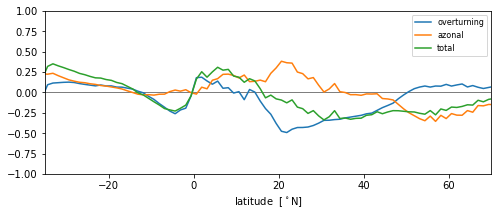

In [16]:
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon2*dz2).sum(dim=['lon2','z2']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon2*dz2).sum(dim=['lon2','z2']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon2*dz2).sum(dim=['lon2','z2']))/1e12

plt.figure(figsize=(8,3))
plt.axhline(0,c='k',lw=.5)
plt.plot(ds.lat1, Fov, label='overturning')
plt.plot(ds.lat1, Faz, label='azonal')
plt.plot(ds.lat1, Ftotal, label='total')
#plt.plot(ds.lat1, Fov+Faz, label='ov+az')

plt.xlim([-35,70])
plt.ylim([-1,1])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [17]:
dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov), Faz=(["lat"], Faz), Ftot=(["lat"], Ftotal)), coords = dict(lat = ds.lat1.values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_100yr.nc')

## FW Labrador

In [20]:
#Rewrite all fields to -180-180 to be able to select regions within Atlantic

def lon180(ds):
    "Rewrite 0-360 longitude to -180-180"
    ds.coords['lon2'] = (ds.coords['lon2'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon2)
    return ds

ds = lon180(ds)
salt = lon180(salt)
vvel = lon180(vvel)
regiont = lon180(regiont)

#1-D array with spacing of depth grid
dz2 = np.zeros(len(ds.z2))
dz2[0] = ds.z2[0].values*2
depth = dz2[0]
for i in range(1,len(ds.z2)):
    dz2[i] = (ds.z2[i].values-depth)*2
    depth = depth+dz2[i]
dz2 = dz2*100 #Depth spacing. Units: cm
ds['dz2'] = xr.DataArray(data=dz2, dims=("z2"))
dz2 = ds.dz2

#2-D array with spacing of horizontal grid 
r = 6.37122e8 #radius Earth in cm
dlon2 = np.deg2rad(1.25)*r*np.cos(np.deg2rad(ds.lat1)) #Lon spacing. Units: cm. Interpolating to the T-grid

a = dlon2
dlon2 = np.zeros([len(ds.lat1),len(ds.lon2)])
for i in range(len(ds.lon2)):
    dlon2[:,i]=a.values
ds['dlon2']=xr.DataArray(data = dlon2, dims=("lat1","lon2"))
dlon2 = ds.dlon2

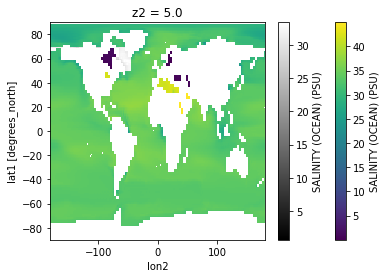

In [21]:
#check region
salt[0].plot()
salt[0].where(regiont>2).where(ds.lon2<-45).where(ds.lat1>=50).where(ds.lat1<70).plot(cmap='gray')

In [22]:
SALT = salt.where(regiont>2).where(ds.lon2<-45).where(ds.lat1>=50).where(ds.lat1<70) #[g/kg]
VVEL = vvel.where(regiont>2).where(ds.lon2<-45).where(ds.lat1>=50).where(ds.lat1<70) #cm/s
VVEL = VVEL*SALT/SALT

#zonal mean components 
VVEL_zm = VVEL.mean(dim='lon2')
SALT_zm = SALT.mean(dim='lon2')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components 
SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon2*dz2).sum(dim=['lon2','z2']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon2*dz2).sum(dim=['lon2','z2']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon2*dz2).sum(dim=['lon2','z2']))/1e12

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[115:130]), Faz=(["lat"], Faz[115:130]), Ftot=(["lat"], Ftotal[115:130])), coords = dict(lat = ds.lat1[115:130].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Lab_100yr.nc')

## FW Fram Strait

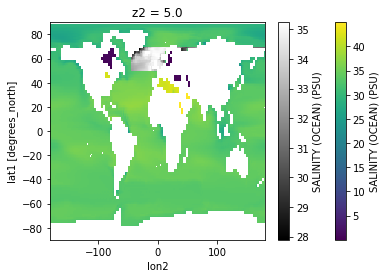

In [23]:
#check region
salt[0].plot()
salt[0].where(regiont>2).where(ds.lon2>=-45).where(ds.lat1>=50).where(ds.lat1<70).plot(cmap='gray')

In [24]:
SALT = salt.where(regiont>2).where(ds.lon2>=-45).where(ds.lat1>=50).where(ds.lat1<70) #  [g/kg]
VVEL = vvel.where(regiont>2).where(ds.lon2>=-45).where(ds.lat1>=50).where(ds.lat1<70) #cm/s
VVEL = VVEL*SALT/SALT

#zonal mean components
VVEL_zm = VVEL.mean(dim='lon2')
SALT_zm = SALT.mean(dim='lon2')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon2*dz2).sum(dim=['lon2','z2']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon2*dz2).sum(dim=['lon2','z2']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon2*dz2).sum(dim=['lon2','z2']))/1e12

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[115:130]), Faz=(["lat"], Faz[115:130]), Ftot=(["lat"], Ftotal[115:130])), coords = dict(lat = ds.lat1[115:130].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Fram_100yr.nc')

## FW Bering Strait

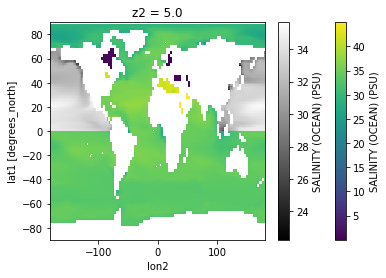

In [25]:
#check region
salt[0].plot()
salt[0].where(regiont==2).where(ds.lat1>0).plot(cmap='gray')

In [26]:
if experiment == 'E280':
    SALT = salt.where(regiont==2).where(ds.lat1>0) #  [g/kg]

    VVEL = vvel.where(regiont==2).where(ds.lat1>0) #cm/s
    VVEL = VVEL*SALT/SALT

    #zonal mean components
    VVEL_zm = VVEL.mean(dim='lon2')
    SALT_zm = SALT.mean(dim='lon2')

    SALT_zm_3D = SALT/SALT
    SALT_zm_3D = SALT_zm_3D*SALT_zm

    VVEL_zm_3D = VVEL/VVEL
    VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

    #azonal components
    SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
    VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

    Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon2*dz2).sum(dim=['lon2','z2']))/1e12
    Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon2*dz2).sum(dim=['lon2','z2']))/1e12 
    Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon2*dz2).sum(dim=['lon2','z2']))/1e12

    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[72:-17]), Faz=(["lat"], Faz[72:-17]), Ftot=(["lat"], Ftotal[72:-17])), coords = dict(lat = ds.lat1[72:-17].values))    
    xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_BS_100yr.nc')